# Water Model Calibration

In [236]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import chaospy as cp
from ipypb import track

# Helper Methods

In [237]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        elif objType == "Tank":
            objIter = wn.tanks()
        elif objType == "Reservoir":
            objIter = wn.reservoirs()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [238]:
class ResultHelper():
    def __init__(self,results,convertResultsToHours=True):
        self.results = results
        
        # programatically set nodes
        for nodeKey in results.node.keys():
            self.__dict__[nodeKey] = results.node[nodeKey].T
        
        # progrmatically set links
        for linkKey in results.link.keys():
            self.__dict__[linkKey] = results.link[linkKey].T
        
        if convertResultsToHours:
            self.convertResultsToHours()
            
    def help(self):
        return list(self.__dict__.keys())
        
    def convertResultsToHours(self):
        for prop,value in self.__dict__.items():
            if type(value) == pd.DataFrame:
                value.columns = [float(seconds)/3600.0 for seconds in value.columns]
                
    def returnResult(self,resultType,resultLocationID,time):
        if resultType in self.__dict__.keys():
            resultDF = self.__dict__[resultType]
            if resultLocationID in resultDF.index:
                if time in resultDF.columns:
                    return self.__dict__[resultType].loc[resultLocationID][time]
                else:
                    print(f"{time} is not a valid time")
            else:
                print(f"{resultLocationID} is not a valid element in the network")
        else:
            print(f"{resultType} is not a valid property for ResultAnalyzer")
            return None

In [345]:
class Sensor():
    def __init__(self,sensorType,name,sensorSTD,dictOfPropertyValues):
        self.sensorType = sensorType
        self.name = name
        self.sensorSTD = sensorSTD
        self.dictOfPropertyValues = dictOfPropertyValues
        self.dictOfPropertyModelEstimates = {k:[] for k in dictOfPropertyValues.keys()}
        
    def calculateProbability(self,resultHelper):
        p = 1.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(sensorObservationValue,self.sensorSTD)
            p *= distribution.pdf(modelResult)
        return p
    
    def calculateProbability_Summed(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += distribution.pdf(sensorObservationValue)
        return p        
    
    def calculateProbability_Summed_Log(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += np.log(distribution.pdf(sensorObservationValue))
        return p       

In [240]:
class WaterNetworkHelper():
    def __init__(self,wn,name="Water Network"):
        self.wn = wn
        self.updatePipes()
        self.name = name
        
    def updatePipes(self):
        self.pipes = extractDataFrame(self.wn).set_index("name")
        self.nodes = extractDataFrame(self.wn,"Junction").set_index("name")
        self.tanks = extractDataFrame(self.wn,"Tank").set_index("name")
        self.reservoirs = extractDataFrame(self.wn,"Reservoir").set_index("name")
        
    def setPipeDiameter(self,pipeID,newDiameter):
        pipe = self.wn.get_link(pipeID)
        pipe.diameter = newDiameter
        self.updatePipes()
    
    def setPipeRoughness(self,pipeID,newRoughness):
        pipe = self.wn.get_link(pipeID)
        pipe.roughness = newRoughness
        self.updatePipes()
    
    def setPipeStatus(self,pipeID,newStatus):
        pipe = self.wn.get_link(pipeID)
        pipe.status = newStatus
        self.updatePipes()
            
    def runSimulation(self):
        sim = wntr.sim.EpanetSimulator(self.wn)
        results = ResultHelper(sim.run_sim())
        return results        
    
    def plotNetwork(self,figsize=(10,10),link_attribute=None,node_attribute=None):
        fig,ax = plt.subplots(figsize=figsize)
        wntr.graphics.plot_network(self.wn, title=self.name,ax=ax,node_attribute=node_attribute,link_attribute=link_attribute)

In [478]:
class Calibrator():
    def __init__(self,elementName,elementProperty,distribution):
        self.elementName = elementName
        self.elementProperty = elementProperty
        self.prior = distribution # type of distribution
        self.values = []
        self.proposedValues = []
        
    def generateProposal(self):
        return self.prior.rvs()
    
    def generateTransition(self,currentValue=None,σ=None):
        if not currentValue:
            currentValue = self.values[-1]
        if not σ:
            σ = self.prior.std()
        # simple gaussian case
        dist = stats.norm(currentValue,σ)
        return dist.rvs()
    
    def calculateProbability(self,value):
        return self.prior.pdf(value)
    
    def calculateProbability_Transition(self,value):
        dist = stats.norm(self.values[-1],self.prior.std())
        return dist.pdf(value)
        
    def setValue(self,waterNetworkHelper,newValue):
        if self.elementProperty == "diameter":
            waterNetworkHelper.setPipeDiameter(self.elementName,newValue)
        elif self.elementProperty == "roughness":
            waterNetworkHelper.setPipeRoughness(self.elementName,newValue)
        elif self.elementProperty == "status":
            waterNetworkHelper.setPipeStatus(self.elementName,newValue)
            
    def plot(self,trueValue,burnin=0.0):
        columnName = f"{self.elementName} {self.elementProperty}"
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratorDFToPlot = pd.DataFrame({columnName:valuesSubset})
        fig,ax = plt.subplots(figsize=(10,10))
        calibratorDFToPlot.plot(kind="hist",ax=ax,legend=False,density=True)
        ax.axvline(trueValue,color="red",ls="--")
        ax.set_title(f'{columnName}\nCalibrated Mean: {calibratorDFToPlot[columnName].mean():.1f}, Calibrated Median: {calibratorDFToPlot[columnName].median():.1f}\nTrue Value: {trueValue:.1f}\nPrior Mean: {self.prior.mean():.1f}')
        ax.set_xlabel(calibrator1.elementProperty)
        
        # add the prior distribution
        priorEstimates = []
        for i in range(0,10000):
            priorEstimates.append(self.generateProposal())
        priorEstimatesDF = pd.DataFrame({"Prior":priorEstimates})
        priorEstimatesDF.plot(kind="hist",ax=ax,color="orange",alpha=0.1,label="Prior",density=True)
        return ax

# Set up Base (True Model)

(<matplotlib.collections.PathCollection at 0x278c0390308>,
 <matplotlib.collections.LineCollection at 0x278c0390088>)

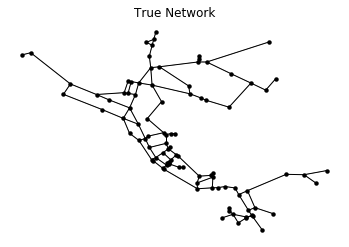

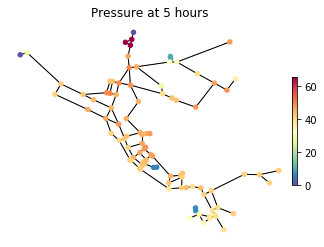

In [242]:
# Create a water network model
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_true, title="True Network")

# Simulate hydraulics
sim_true = wntr.sim.EpanetSimulator(wn_true)
results_true = sim_true.run_sim()

# Plot results on the network
pressure_at_5hr = results_true.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn_true, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

# Set up Altered Model

In [243]:
testNetwork = WaterNetworkHelper(wn_true)

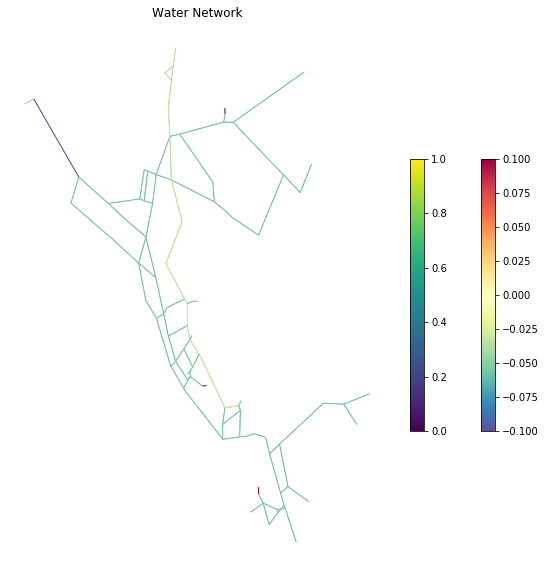

In [244]:
testNetwork.plotNetwork(link_attribute="roughness",node_attribute="demand")

In [245]:
testSensor = Sensor("demand","15",0.01,{0.0:.04,0.25:0.038})

In [246]:
testNetwork.setPipeDiameter("20",4)

In [247]:
testNetwork.pipes

,bulk_rxn_coeff,cv,diameter,end_node,end_node_name,flow,initial_setting,initial_status,length,link_type,minor_loss,roughness,setting,start_node,start_node_name,status,tag,vertices,wall_rxn_coeff
name,,,,,,,,,,,,,,,,,,,
20,None,False,4.0000,20,20,None,None,1,30.1752,Pipe,0.0,199.0,None,3,3,1,None,[],None
40,None,False,2.5146,40,40,None,None,1,30.1752,Pipe,0.0,199.0,None,1,1,1,None,[],None
50,None,False,2.5146,50,50,None,None,1,30.1752,Pipe,0.0,199.0,None,2,2,1,None,[],None
60,None,False,0.6096,60,60,None,None,1,375.2088,Pipe,0.0,140.0,None,River,River,1,None,[],None
101,None,False,0.4572,101,101,None,None,1,4328.1600,Pipe,0.0,110.0,None,10,10,1,None,[],None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,None,False,0.3048,275,275,None,None,1,91.4400,Pipe,0.0,130.0,None,201,201,1,None,[],None
325,None,False,0.2032,271,271,None,None,1,393.1920,Pipe,0.0,130.0,None,269,269,1,None,[],None
329,None,False,0.7620,123,123,None,None,1,13868.4000,Pipe,0.0,140.0,None,61,61,1,None,[],None


In [248]:
testResult = testNetwork.runSimulation()

In [249]:
testResult.flowrate

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,165.75,166.00,166.25,166.50,166.75,167.00,167.25,167.50,167.75,168.00
name,,,,,,,,,,,,,,,,,,,,,
20,-1.417195e-01,-1.402990e-01,-1.389211e-01,-1.375811e-01,-1.918836e-01,-1.908000e-01,-1.897421e-01,-1.887076e-01,-2.286319e-01,-2.280717e-01,...,-1.451487e-01,-1.090683e-01,-1.058429e-01,-1.027298e-01,-9.972593e-02,-5.917176e-02,-5.580604e-02,-5.255272e-02,-4.941132e-02,-1.403122e-01
40,-2.904171e-02,-2.808642e-02,-2.724869e-02,-2.651397e-02,-6.325308e-02,-6.183808e-02,-6.049300e-02,-5.921391e-02,-7.945831e-02,-7.845762e-02,...,-1.324341e-02,2.365630e-02,2.170186e-02,1.978687e-02,1.791636e-02,4.521635e-02,4.326295e-02,4.135005e-02,3.948253e-02,-1.513647e-02
50,2.077009e-02,1.873905e-02,1.686762e-02,1.513597e-02,1.999953e-02,1.823608e-02,1.656860e-02,1.499001e-02,-7.516096e-03,-8.094080e-03,...,6.486753e-03,1.758446e-02,1.647723e-02,1.544249e-02,1.447229e-02,2.952196e-02,2.817178e-02,2.689148e-02,2.567565e-02,9.665825e-03
60,8.301330e-01,8.297881e-01,8.294440e-01,8.291008e-01,8.240935e-01,8.235860e-01,8.230792e-01,8.225731e-01,8.184308e-01,8.177646e-01,...,8.311462e-01,8.325222e-01,8.323585e-01,8.321950e-01,8.320319e-01,8.334600e-01,8.333978e-01,8.333377e-01,8.332797e-01,8.259247e-01
101,6.176596e-09,6.040704e-09,5.903469e-09,5.904887e-09,2.167266e-01,2.164988e-01,2.162702e-01,2.160413e-01,2.101099e-01,2.097933e-01,...,4.855457e-09,5.173495e-09,5.324818e-09,5.173494e-09,5.326736e-09,6.176607e-09,6.307505e-09,6.308687e-09,6.307505e-09,5.474358e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,8.301330e-01,8.297881e-01,8.294440e-01,8.291008e-01,8.240934e-01,8.235860e-01,8.230792e-01,8.225731e-01,8.184308e-01,8.177646e-01,...,8.311461e-01,8.325222e-01,8.323585e-01,8.321950e-01,8.320319e-01,8.334600e-01,8.333978e-01,8.333377e-01,8.332797e-01,8.259247e-01
330,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
333,-2.890559e-08,-2.961881e-08,-2.976975e-08,-2.980169e-08,-2.981023e-08,-2.981026e-08,-2.981027e-08,-2.981027e-08,-2.981027e-08,-2.981027e-08,...,-2.963528e-08,-2.979323e-08,-2.980666e-08,-2.980951e-08,-2.981011e-08,-2.981026e-08,-2.981027e-08,-2.981027e-08,-2.981027e-08,-2.981027e-08


In [250]:
testResult.pressure

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,165.75,166.00,166.25,166.50,166.75,167.00,167.25,167.50,167.75,168.00
name,,,,,,,,,,,,,,,,,,,,,
10,-0.450075,-0.412128,-0.373861,-0.335356,28.253767,28.271534,28.289356,28.307182,28.764025,28.788130,...,0.907047,0.372047,0.362341,0.353657,0.345960,-0.651304,-0.679442,-0.706920,-0.733592,0.201611
15,28.593653,28.646692,28.699518,28.752102,28.885521,28.962921,29.040127,29.117123,29.999792,30.099110,...,38.713997,34.835175,34.861679,34.887856,34.913708,34.475533,34.484104,34.492184,34.499786,29.216715
20,8.839199,8.904191,8.968536,9.032244,9.095338,9.183337,9.270839,9.357852,9.444395,9.549245,...,9.110826,9.177393,9.227413,9.275949,9.323063,9.368795,9.395933,9.421527,9.445627,9.468287
35,40.612469,40.648396,40.684673,40.721203,41.515282,41.584343,41.653618,41.723015,42.429348,42.531429,...,41.672138,41.488880,41.471233,41.454845,41.439659,40.998650,40.961136,40.924675,40.889191,41.281265
40,3.992880,4.042458,4.090409,4.136927,4.182194,4.290178,4.395748,4.499026,4.600112,4.735765,...,5.229321,5.251928,5.211545,5.174496,5.140712,5.110128,5.032933,4.959072,4.888481,4.821076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
River,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lake,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.992880,4.042458,4.090409,4.136927,4.182194,4.290178,4.395748,4.499021,4.600112,4.735765,...,5.229321,5.251928,5.211545,5.174496,5.140712,5.110128,5.032933,4.959076,4.888481,4.821076


In [251]:
testSensor.calculateProbability(testResult)

1575.5015120581477

In [252]:
testCalibrator = Calibrator("20","diameter",stats.norm(6,2))

# Setting Up

In [455]:
def π_Transition(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateTransition()
        estimatesDict[calibrator] = rv
    return estimatesDict             

In [253]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateProposal()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [254]:
π([testCalibrator])

{<__main__.Calibrator at 0x278b38d8608>: 5.854396914712878}

In [479]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
#         pi = calibrator.calculateProbability(parameterValue)
        pi = calibrator.calculateProbability_Transition(parameterValue)
        p *= pi
    return p

In [468]:
π_Prior({testCalibrator:6.3})

AttributeError: 'Calibrator' object has no attribute 'calculateProbability_Transition'

In [435]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Liklihood(listOfSensors,modelResult):
    logLiklihood = 0.0
    for sensor in listOfSensors:
        logLiklihood += sensor.calculateProbability_Summed_Log(modelResult)
#         logLiklihood += sensor.calculateProbability_Summed(modelResult)
#     logLiklihood = np.log(logLiklihood)
    return logLiklihood

In [436]:
π_Log_Liklihood(listOfSensors,currentModelResult)

179.4108604512804

In [258]:
np.log(.3) + np.log(.5)

-1.8971199848858813

In [259]:
np.log(.8)

-0.2231435513142097

In [260]:
def MCMC():
    return None

In [261]:
def GA():
    return None

In [262]:
def setParameterValues(proposedParameters):
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.values.append(proposedParameterValue)

# MCMC Step By Step

In [480]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

# Set the calibrators
calibrator1 = Calibrator("20","roughness",stats.norm(190,20))
calibrator2 = Calibrator("40","roughness",stats.norm(200,10))
calibrator3 = Calibrator("333","roughness",stats.norm(130,20))

listOfCalibrators = [calibrator1,calibrator2,calibrator3]

In [481]:
listOfCalibrators = []
trueValues = {}
pAddCalibrator = 0.05
for i,row in waterNetwork.pipes.iterrows():
    rand = np.random.random()
    if rand < pAddCalibrator:
        actualRoughness = row["roughness"]
        dist = stats.norm(actualRoughness,15)
        randomRoughness = dist.rvs()
        calibrator = Calibrator(i,"roughness",stats.norm(randomRoughness,15))
        trueValues[calibrator] = actualRoughness
        listOfCalibrators.append(calibrator)

trueValues = {calibrator1:199,calibrator2:199,calibrator3:140}

In [482]:
listOfSensors = []
pAddSensor = 0.2
for i,row in testResult.flowrate.iterrows():
    sensorProperty = "flowrate"
    sensorName = i
    sensorSTD = 0.001
    sensorDict = {}
#     for time in testResult.pressure.columns:
#         sensorDict[time] = row[time]
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    rand = np.random.random()
    if rand < pAddSensor:
        listOfSensors.append(sensor)

sensor1 = Sensor("pressure","15",2,{0.0:28.593653,0.25:28.646692})
sensor2 = Sensor("pressure","40",1,{0.0:3.992880,0.25:4.042458})

listOfSensors = [sensor1,sensor2]

In [483]:
iterations = []
acceptanceRatios = []
isAccepted = []

In [484]:
currentParameters = π(listOfCalibrators)
for calibrator,proposedParameterValue in currentParameters.items():
    calibrator.values.append(proposedParameterValue)
    calibrator.setValue(waterNetwork,proposedParameterValue)
currentModelResult = waterNetwork.runSimulation()

In [485]:
n = 100

In [486]:
for i in track(range(0,n)):
    iterations.append(i)
    
    # generate a set of proposed values as a starting point
    proposedParameters = π_Transition(listOfCalibrators)
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.proposedValues.append(proposedParameterValue)
        # udpate the model
        calibrator.setValue(waterNetwork,proposedParameterValue)
    
    # run the model
    try:
        modelResult = waterNetwork.runSimulation()

        # calculate the acceptance probabilities
        α_1 = np.log(π_Prior(proposedParameters))
        α_2 = π_Log_Liklihood(listOfSensors,modelResult)
        α_3 = np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
        α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
        α = np.exp(α_1 + α_2 - α_3 - α_4)
        α = min(1.0,α)
        acceptanceRatios.append(α)
        accepted = False

        # decide if we accept
        if α == 1: # accept
            setParameterValues(proposedParameters)
            currentParameters = proposedParameters
            currentModelResult = modelResult
            accepted = True
        else: # draw a random number and take the probability based on α
            rand = np.random.random()
            if rand < α: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else:
                setParameterValues(currentParameters)

        # update our iteration
        # update parameter histories
        isAccepted.append(accepted)
    except:
        pass

# generate the return data frame


 [████████████████████████████████████████████████████████████] 100/100 [00:26<00:00, 0.26s/it]

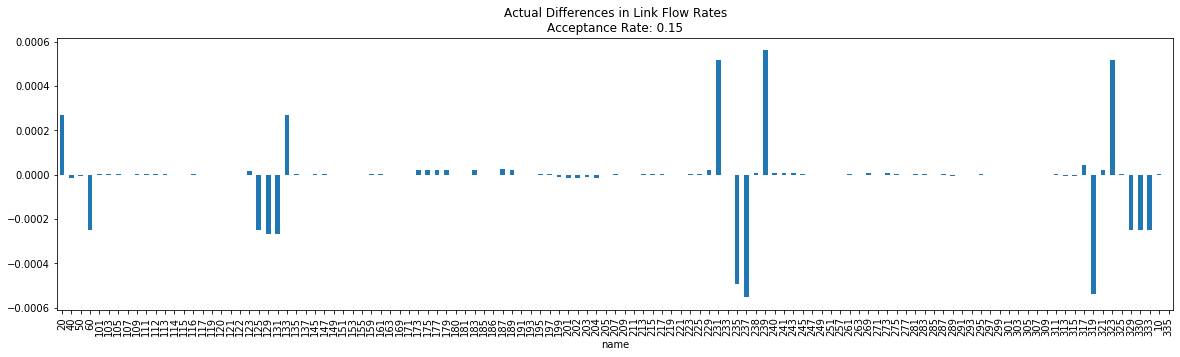

In [487]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.flowrate[5.00] - currentModelResult.flowrate[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Link Flow Rates\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

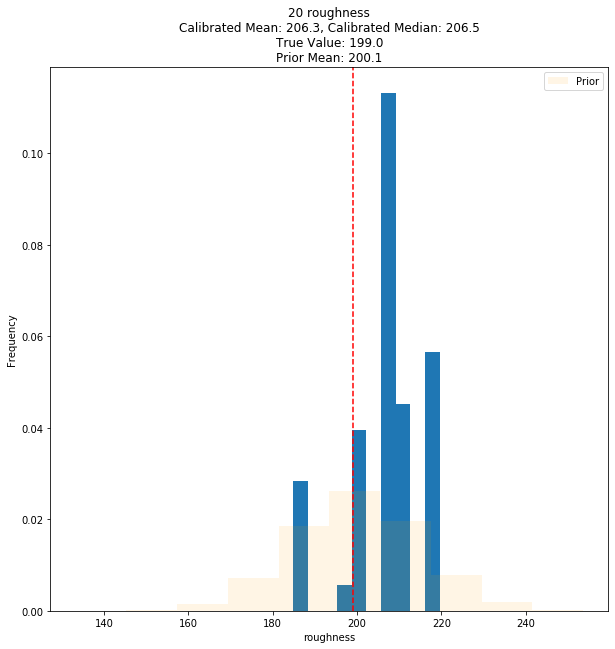

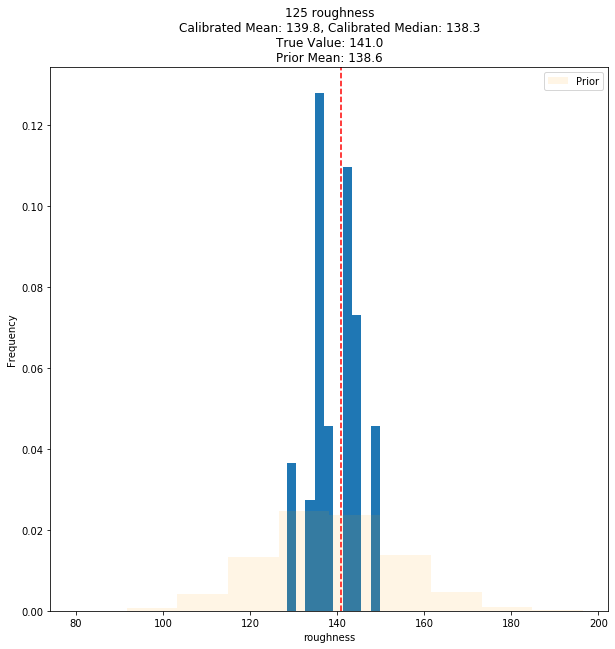

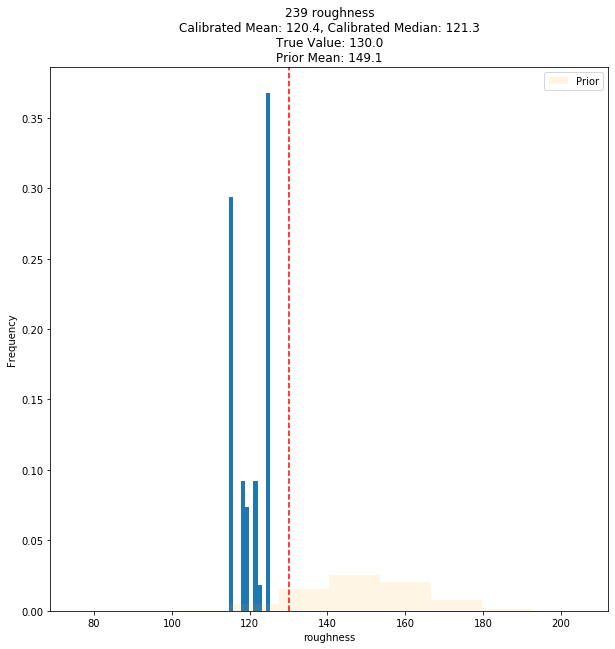

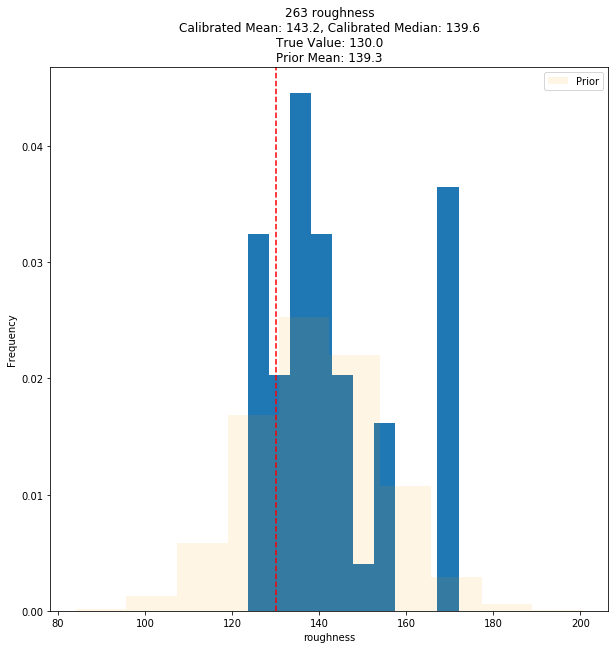

In [488]:
for i in range(0,len(listOfCalibrators)):
    listOfCalibrators[i].plot(trueValues[listOfCalibrators[i]],burnin=0.5)

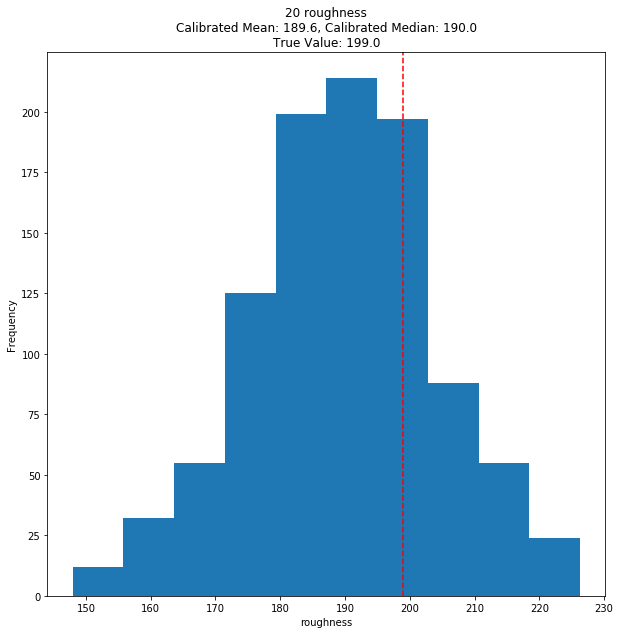

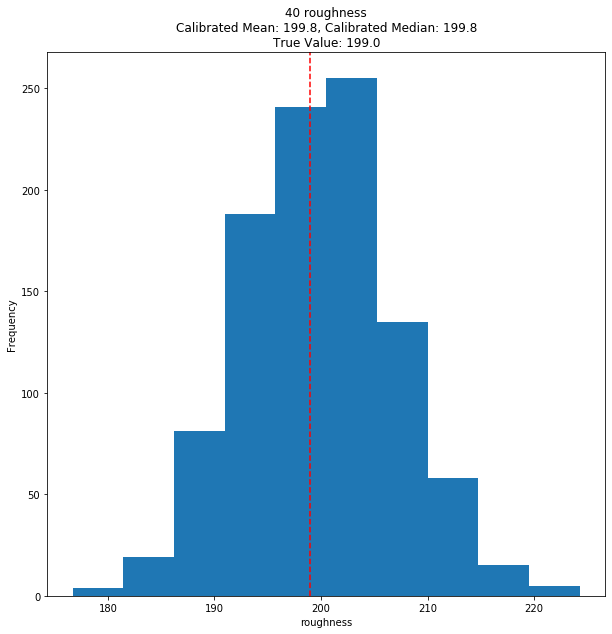

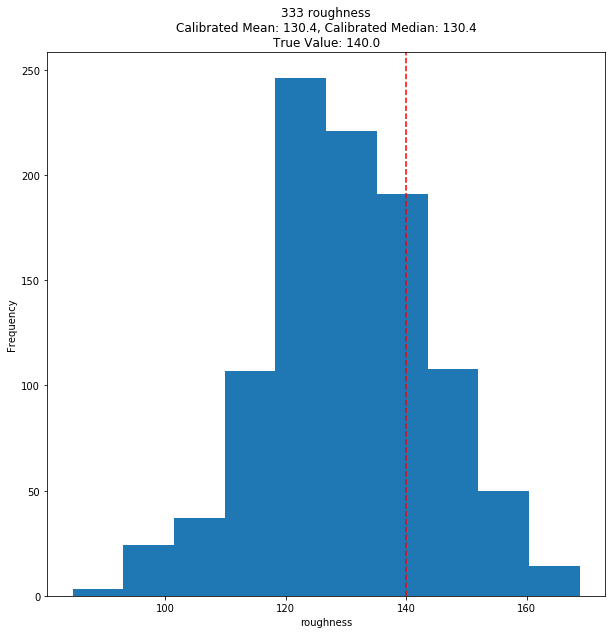

In [39]:
ax1 = calibrator1.plot(trueValues[calibrator1])
ax2 = calibrator2.plot(trueValues[calibrator2])
ax3 = calibrator3.plot(trueValues[calibrator3])

In [84]:
np.sum(isAccepted)/len(isAccepted)

0.15

# Let's do this

For simplicity, we are treating the only system states as flow rate, and the only parameters as pipe roughness

## Inputs

In [ ]:
class Parameter():
    def __init__(self,pipeName,value,distribution=None,isFixed=True):
        self.pipeName = pipeName
        self.value = value
        self.distribution = distribution
        self.isFixed = isFixed
        
    def generateValue(self):
        return 0
    
    def probabilityOfValue(self):
        return 0

In [ ]:
class Model():
    def __init__(self,wn,listOfParameters):
        self.wn = wn
        self.listOfParameters = listOfParameters

### Fixed Inputs

### Distributions of Priors

### Trusted System States and their Distributions (Uncertainty) for Calibration

## Methods

### $\pi$- Generates the random values for the parameters being tested

In [ ]:
def π():
    return 0

### $\pi_{prior}$- Calculates the probability that a set of parameter 'states' are pulled from their distributions

In [ ]:
def π_prior():
    return 0

### $\pi_{log liklihood}$- The sum of the log liklihood of each resulting system state matching the trusted system state

In [ ]:
def π_logLikelihood():
    return 0

### MCMC

In [ ]:
def MCMC():
    return 0

1. Set the parameters for the model, both fixed and pulling from distributions
2. Run the model with the selected parameters
3. Compare model results to the "sensor" feeds
4. Calculate the acceptance ratio

# Try professional library

In [415]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

ModuleNotFoundError: No module named 'arviz'